# Crime Classification San Fransisco

## Importation des modules

In [99]:
!where python

C:\Users\frank\anaconda3\python.exe
C:\Users\frank\AppData\Local\Microsoft\WindowsApps\python.exe


In [100]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import Callback

## 1. Charger les données

In [102]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## 2. Feature engeeniring

### --- Dates ---

In [105]:
train_data['Dates'] = pd.to_datetime(train_data['Dates'])
test_data['Dates'] = pd.to_datetime(test_data['Dates'])

train_data['Hour'] = train_data['Dates'].dt.hour
train_data['Day'] = train_data['Dates'].dt.day
train_data['Month'] = train_data['Dates'].dt.month
train_data['Year'] = train_data['Dates'].dt.year
train_data['DayOfWeek_num'] = train_data['Dates'].dt.dayofweek

test_data['Hour'] = test_data['Dates'].dt.hour
test_data['Day'] = test_data['Dates'].dt.day
test_data['Month'] = test_data['Dates'].dt.month
test_data['Year'] = test_data['Dates'].dt.year
test_data['DayOfWeek_num'] = test_data['Dates'].dt.dayofweek

### --- Encodage One-Hot (DayOfWeek et PdDistrict) ---

In [107]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

train_ohe = encoder.fit_transform(train_data[['DayOfWeek', 'PdDistrict']])
test_ohe = encoder.transform(test_data[['DayOfWeek', 'PdDistrict']])

### --- Coordonnées géographiques ---

In [109]:
scaler = StandardScaler()
train_data[['X', 'Y']] = scaler.fit_transform(train_data[['X', 'Y']])
test_data[['X', 'Y']] = scaler.transform(test_data[['X', 'Y']])

### --- Fusionner les features ---

In [111]:
train_features = np.hstack((
    train_data[['Hour', 'Day', 'Month', 'Year', 'X', 'Y']].values,
    train_ohe
))

test_features = np.hstack((
    test_data[['Hour', 'Day', 'Month', 'Year', 'X', 'Y']].values,
    test_ohe
))

### --- Catégories (Y_train) ---

In [113]:
categories = train_data['Category'].unique()
categories.sort()

category_mapping = {category: idx for idx, category in enumerate(categories)}
train_data['Category_encoded'] = train_data['Category'].map(category_mapping)

y_train = np.eye(len(categories))[train_data['Category_encoded']]

## 3. Division en jeu d'entraînement et de validation

In [115]:

X_train, X_val, y_train, y_val = train_test_split(train_features, y_train, test_size=0.2, random_state=42)


## 4. Modélisation avec un MLP

In [117]:
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    #Dropout(0.3),  # Désactive 30% des neurones aléatoirement
    Dense(64, activation='relu'),
    #Dropout(0.3),  
    Dense(len(categories), activation='softmax')  # 39 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\frank\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 5. Entraînement

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
21952/21952 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.1686 - loss: 4.7443 - val_accuracy: 0.2011 - val_loss: 2.6842
Epoch 2/20
21952/21952 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.2021 - loss: 2.6830 - val_accuracy: 0.2017 - val_loss: 2.6811
Epoch 3/20
21952/21952 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - accuracy: 0.2130 - loss: 2.6655 - val_accuracy: 0.2100 - val_loss: 2.6750
Epoch 4/20
21952/21952 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.2135 - loss: 2.6602 - val_accuracy: 0.2135 - val_loss: 2.6516
Epoch 5/20
21952/21952 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.2139 - loss: 2.6524 - val_accuracy: 0.2199 - val_loss: 2.6443
Epoch 6/20
21952/21952 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.2159 - loss: 2.6469 - val_accuracy: 0.2204 - val_loss: 2.6402
Epoch 7/20
21952/21952 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - accuracy: 0.2195 - loss: 2.6422 - val_accuracy: 0.2218 - val_loss: 2.6386
Epoch 8/20
21952/21952 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 

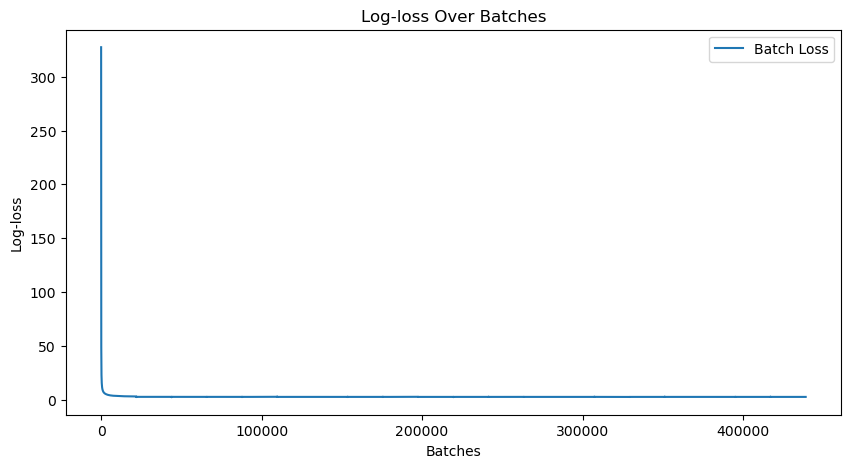

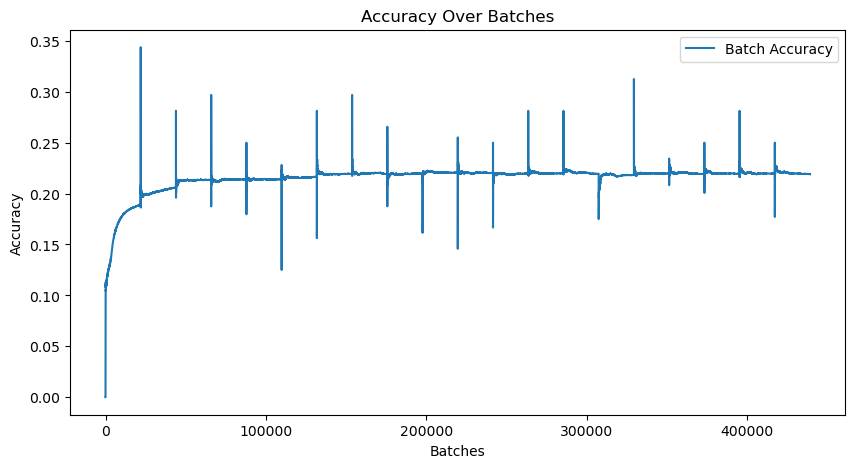

In [119]:
# Définir le callback BatchHistory
class BatchHistory(Callback):
    def on_train_begin(self, logs=None):
        self.batch_logs = {'batch_loss': [], 'batch_accuracy': []}

    def on_batch_end(self, batch, logs=None):
        self.batch_logs['batch_loss'].append(logs['loss'])
        self.batch_logs['batch_accuracy'].append(logs['accuracy'])

# Initialiser les callbacks
batch_history = BatchHistory()
tqdm_callback = TqdmCallback(verbose=1)

# Entraîner le modèle avec les deux callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[batch_history, tqdm_callback]  # Inclure les deux
)

# Tracer la log-loss par batch
plt.figure(figsize=(10, 5))
plt.plot(batch_history.batch_logs['batch_loss'], label='Batch Loss')
plt.title('Log-loss Over Batches')
plt.xlabel('Batches')
plt.ylabel('Log-loss')
plt.legend()
plt.show()

# Tracer l'accuracy par batch
plt.figure(figsize=(10, 5))
plt.plot(batch_history.batch_logs['batch_accuracy'], label='Batch Accuracy')
plt.title('Accuracy Over Batches')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### --- Courbes d'entrainement ---

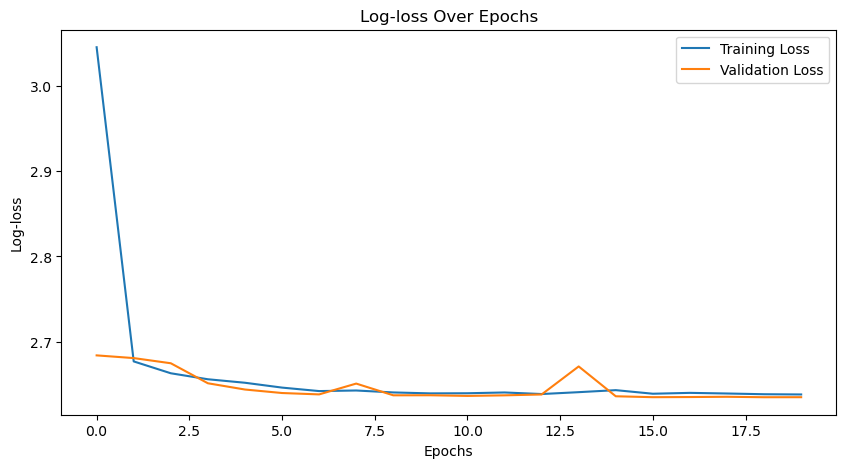

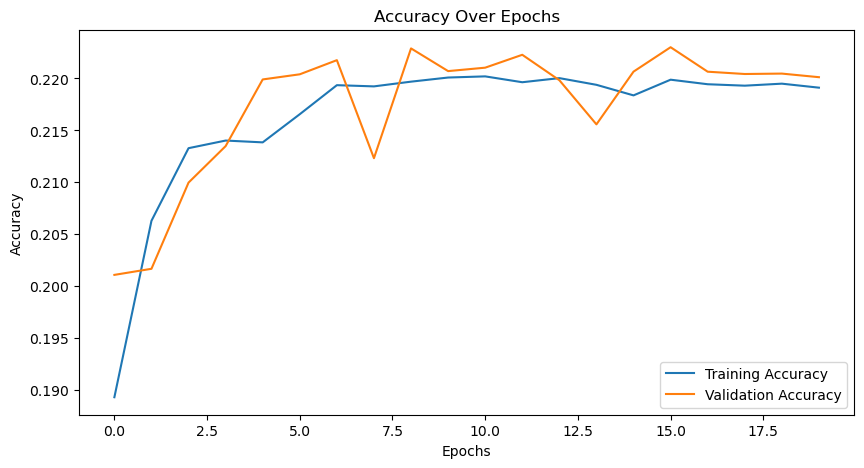

In [121]:
# Log-loss (loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Log-loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log-loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 6. Prédictions sur l'ensemble de test

In [123]:
predictions = model.predict(test_features)

27634/27634 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step


## 7. Création du fichier de soumission

In [125]:
submission = pd.DataFrame(predictions, columns=categories)
submission['Id'] = test_data['Id']

# Réorganiser pour placer 'Id' en premier
submission = submission[['Id'] + [col for col in submission.columns if col != 'Id']]


submission.to_csv('submission.csv', index=False)

In [126]:
#sub = pd.read_csv('submission.csv')
print(submission.head())

   Id     ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  DISORDERLY CONDUCT  \
0   0  0.002499  0.099024    0.000502  0.000594  0.044818            0.004581   
1   1  0.002556  0.099509    0.000500  0.000612  0.044652            0.004573   
2   2  0.000789  0.069207    0.000538  0.000139  0.046006            0.004326   
3   3  0.002302  0.097203    0.000510  0.000534  0.045366            0.004607   
4   4  0.002302  0.097203    0.000510  0.000534  0.045366            0.004607   

   DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  DRUNKENNESS  ...  \
0                     0.003104       0.047378     0.003760  ...   
1                     0.003119       0.047297     0.003727  ...   
2                     0.002198       0.044517     0.004839  ...   
3                     0.003050       0.047620     0.003876  ...   
4                     0.003050       0.047620     0.003876  ...   

   SEX OFFENSES NON FORCIBLE  STOLEN PROPERTY   SUICIDE  SUSPICIOUS OCC  \
0                   0.000316       

In [127]:
print(submission.columns)

Index(['Id', 'ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC',
       'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES',
       'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING',
       'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON',
       'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT',
       'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY',
       'SECONDARY CODES', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE',
       'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS',
       'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS'],
      dtype='object')


In [128]:
print(submission.shape)


(884262, 40)
